# Selfmade memory based

In [1]:
import io
import zipfile
import requests

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

from scipy.spatial.distance import (
    correlation as orig_correlation,
    cosine as orig_cosine
)
from surprise import KNNWithMeans, Dataset, Reader
from ranx import Qrels, Run, evaluate

from typing import Union, Callable

from IPython.display import HTML
header_pattern = "<text style='font-size:20px'>{}</text>"

## Task generation

In [2]:
np.random.seed(10)
r_width = 100
r_height = 500

R, group = make_blobs(
    n_samples=r_height,
    n_features=r_width,
    centers=100,
    random_state=10
)
R = np.round((R-R.min())*10/(R.max()-R.min())).astype(int)

# add bias for each object
bias = np.random.randint(-2,3, [R.shape[0], 1])
R = R + bias
# sometimes bias can lead to ratings
R = np.where(R<0, 0, R)
R = np.where(R>10, 10, R)
R[:10, :]

array([[ 7,  6,  3,  8,  1,  6,  2,  1,  1,  7,  4,  3,  0,  7,  5,  2,
         2,  0,  0,  5,  1,  4,  5,  2,  6,  3,  5,  7,  5,  6,  4,  5,
         6,  7,  1,  5,  2,  1,  7,  6,  1,  0,  4,  1,  2,  2,  3,  1,
         0,  4,  5,  1,  6,  7,  5,  0,  5,  6,  1,  4,  2,  1,  7,  3,
         1,  3,  1,  6,  2,  3,  4,  6,  4,  7,  7,  2,  7,  2,  5,  2,
         7,  7,  7,  4,  1,  4,  6,  4,  3,  6,  7,  2,  8,  5,  8,  5,
         7,  6,  5,  4],
       [ 4,  8,  6,  7,  7,  7,  6,  7,  7,  7,  9,  9,  6,  4,  5,  6,
         5,  9,  7,  9,  7,  8,  3,  6,  8,  8,  6, 10, 10,  4,  4,  7,
         4,  5, 10,  9,  6,  4,  8,  9,  5,  7,  4,  8,  3,  6,  6, 10,
         6,  5,  3,  6,  8,  4,  6,  7,  6,  7,  3,  6,  9,  9,  3,  9,
         6,  7,  6,  4,  4,  7,  4,  3, 10,  7, 10,  8,  5,  6, 10,  7,
         9,  4,  9,  8,  6,  5,  5,  3, 10,  9,  6,  4, 10, 10,  5, 10,
         4,  9,  9,  9],
       [ 0,  6,  4,  0,  4,  0,  6,  0,  6,  4,  1,  1,  4,  4,  1,  6,
         2,  5

In [3]:
np.random.seed(10)
R_frame = pd.Series(
    R.ravel(),
    index = pd.MultiIndex.from_tuples(
        [
            (j,i)
            for j in np.arange(R.shape[0]) 
            for i in np.arange(R.shape[1])
        ],
        names = ["object", "item"]
    ),
    name = "rank"
).to_frame()
R_frame.sample(10)

,,rank
object,item,
276,32,6
361,19,2
47,96,9
36,48,5
245,1,2
378,85,6
212,55,7
203,25,5
143,24,7


In [4]:
R_fr_train, R_fr_test = train_test_split(
    R_frame, 
    train_size=0.8, 
    random_state=100
)

# preparing test/train samples representation as
# as user/item matrix
R_mat_train = pd.DataFrame(
    R_fr_train["rank"].unstack(),
    columns = R_frame.index.get_level_values(1).unique()
)
R_mat_test = pd.DataFrame(
    R_fr_test["rank"].unstack(),
    columns = R_frame.index.get_level_values(1).unique()
)

metrics = [
    "ndcg@3",
    "ndcg@5",
    "ndcg@10"
]
R_fr_test[["object_str", "item_str"]] = \
    R_fr_test.index.to_frame()[["object", "item"]].astype("str")

qrels = Qrels.from_df(
    df=R_fr_test.reset_index(),
    q_id_col="object_str", 
    doc_id_col="item_str",
    score_col="rank"
)

## Random predict

In [5]:
R_fr_test["random_predict"] = np.random.rand(R_fr_test.shape[0])
R_fr_test.sample(10)

,,rank,object_str,item_str,random_predict
object,item,,,,
148,29,2,148,29,0.437084
469,68,8,469,68,0.256724
116,43,5,116,43,0.244048
70,83,2,70,83,0.688916
71,38,1,71,38,0.858272
59,29,0,59,29,0.662598
120,20,7,120,20,0.405964
481,59,1,481,59,0.014950
116,94,3,116,94,0.616384


In [6]:
random_run = Run.from_df(
    df=R_fr_test.reset_index(),
    q_id_col="object_str",
    doc_id_col="item_str",
    score_col="random_predict"
)

random_eval = evaluate(
    qrels, 
    random_run, 
    metrics=metrics
)
random_eval

{'ndcg@3': 0.5912792255135155,
 'ndcg@5': 0.6062122843515301,
 'ndcg@10': 0.6699952241686727}

## surprise

In [7]:
reader = Reader(
    rating_scale=(
        R.min().min(), R.max().max()
    )
)
train_set = Dataset.load_from_df(
    df=R_fr_train["rank"].reset_index(), 
    reader=reader
).build_full_trainset()
algo = KNNWithMeans().fit(train_set)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [8]:
R_fr_test["surpr_predict"] = [
    algo.predict(uid=uid, iid=iid).est 
    for uid, iid in R_fr_test.index
]

In [9]:
surprise_run = Run.from_df(
    df=R_fr_test.reset_index(),
    q_id_col="object_str",
    doc_id_col="item_str",
    score_col="surpr_predict"
)
surpr_evaluate = evaluate(
    qrels, 
    surprise_run, 
    metrics=metrics
)

## Similarity measure

**Note** Many sources use difference instead of similarity, but similarity is the inverse of difference, so you can search not for items that have the smallest difference, but for items that have the strongest similarity.

We need a method to estimate how close the objects are to each other. The following cell defines such a function - it implements Pearson's correlation coefficient, which can solve some problems related to the RecSys domain.

In [10]:
def correlation(
        a : np.ndarray,
        b : np.ndarray
        ) -> float:
    '''
    Pearson correlation coefficient modified
    for our requirements. In particular, empty 
    handling

    Parameters
    ----------
    a : (N,) np.ndarray
        input array;
    b : (N, ) np.ndarray
        input array;

    Returns
    ----------
    out : float
        The Pearson correlation coefficient is 
        computed using only the common items 
        for both arrays. If it's not possible 
        to compute the coefficient, it returns 0, 
        indicating neutral similarity.
        The coefficient is a number ranging from -1 to 1.
    '''
    cond = ~(np.isnan(a) | np.isnan(b))
    # in case if there are only two
    # observations it's impossible
    # to compute coorrelation coeficient
    if sum(cond) <=1:
        return 0.

    sub_a = a[cond]
    sub_b = b[cond]
    
    variation_a = (sub_a - sub_a.mean())
    variation_b = (sub_b - sub_b.mean())

    # to compute pirson correlation coefficient
    # all variables should have some variation
    if (variation_a==0).all() or (variation_b==0).all():
        return 0.
    
    cov = (variation_a*variation_b).sum()
    return cov/np.sqrt(
        (variation_a**2).sum()*(variation_b**2).sum()
    )

Here are some cases where this function has been used and the result.

In [11]:
result = correlation(
    np.array([0,1,2,3,4]),
    np.array([5,6,7,8,9])
)
print("Total correlation -", result)
result = correlation(
    np.array([np.NaN, 1, 2, np.NaN]),
    np.array([10, 10, 20, np.NaN])
)
print("Total correlation with empty -", result)
result = correlation(
    np.array([1,1,1,1]),
    np.array([3,2,1,2])
)
print("Constant variable -", result)
result = correlation(
    np.array([np.NaN, 2, np.NaN, 3]),
    np.array([1, np.NaN, 10, np.NaN])
)
print("Not enough common elements -", result)

Total correlation - 1.0
Total correlation with empty - 1.0
Constant variable - 0.0
Not enough common elements - 0.0


## Prediction function

We need methods to create predictions based on results of the previous steps. The following cell realises the classical formula for generating predicsts based on collaboration:

$$\frac{(\sum_{i}r_{ij}-\overline{r_i})sim_i}{\sum_i{|sim_i|}}$$

Where:

- $r_{ij}$  - relevance of the $j$-th item for the $i$-th user of the collaboration.
- $\overline{r_i}$ - average relevance of the $i$-th user.
- $sim_i$ similarity of the $i$-th object of the collaboration to the object for which we are making a prediction.

In [12]:
def basic_prediction(
        collaboration : np.ndarray,
        similarities : np.ndarray
        ) -> np.ndarray:
    """
    Basic function for creating prediction.
    Uses formula
    \frac{(\sum_{i}x_{ij}-\overline{x_i})sim_i}{\sum_i{|sim_i|}}.
    
    items that have no observable preferences 
    for any user in the collation will simply
    be omitted from the result;.
    
    Parameters
    ----------
    collaboration : np.ndarray (
        <users number>, 
        <games number>
        )
        relevances matrix for collaboration;
    relevances : np.ndarray (<items number>)
        relavences of the user under consdieration;
    similarities : np.ndarray (<observations number>)
        similarities of the users from 
        collaboration to user under consideration.
    
    Returns
    -------
    out : np.ndarray(<items number>)
        scores of the items under consideration.
    """
    users_mean = np.nanmean(collaboration, axis=1, keepdims=1)
    weighed_collab = (collaboration - users_mean)*similarities[:, np.newaxis]
    res = np.nansum(weighed_collab, axis=0)/np.abs(similarities).sum()
    
    # items that have not been played by 
    # any of the users should have nan
    is_empty = np.isnan(collaboration).all(axis=0)
    res[is_empty] = np.NaN

    return res

Consider how it works.

We will consider collaborations that have a matrix of relevance:

$$P_u=\left( \begin{array} \\
2,7,9,- \\
0,-,3,-
\end{array}\right)
$$

And estimations of similarity:

$$
\overline{sim} = 
\left( 
\begin{array}\\
0.7, \\
0.6
\end{array} 
\right)
$$

The average relevance of the users in the collaboration will take shape:

$$\overline{P_u}= 
\left(
\begin{array}\\
6\\
1.5
\end{array}
\right)
$$

Sum of similarities:

$$\sum_i \left|sim_i\right|=0.7+0.6=1.3$$

So we finally can compute estimated relevances for user with this collaboration:

$$\left( \frac{(2-6)0.7 + (0-1.5)0.6}{1.3}, \frac{(7-6)0.7}{1.3}, \frac{(9-6)0.7 + (3-1.5)0.6}{1.5}, - \right)=$$
$$=\left(-2.8461,0.5384,-2.3077, - \right)$$

Now let's try to apply it to the same numbers:

In [13]:
collaboration = np.array([
    [2,7,9, np.NaN],
    [0,np.NaN,3, np.NaN]
])
similarities = np.array([0.7,0.6])

basic_prediction(
    collaboration=collaboration,
    similarities=similarities
)

array([-2.84615385,  0.53846154,  2.30769231,         nan])

## Collaborative filter

Finally, consider a class that implements such an algorithm:

In [14]:
class CollaborativeFilter:
    """
    Сlass implements collaborative filtering based 
    on nearest neighbours.It uses information about 
    previous relevancies, we will call them 
    "fit relevancies", to estimate relevancies for 
    some new users, we will call them "predict relevancies".

    Attributes
    ----------
    similarity : Callable[[np.ndarray, np.ndarray], float]
        Similarity calculation function
        to find collaboration;
    prediction : Callable[[np.ndarray, np.ndarray]
        Function that predicts scores for all items
        available in train sample based on passed
        collaboration;
    sim_threshold : float = -np.inf
        Tresholld that will be used. Objects that have
        distance value is higher are not allowed to pass;
    n_nearest : int = 1000
        Maximum number of rows that can be
        included to the collaboration.
    """
    def __init__(
            self, 
            similarity : Callable[[np.ndarray, np.ndarray], float] = correlation,
            prediction : Callable[[np.ndarray, np.ndarray], float] = basic_prediction,
            sim_threshold : float = -np.inf,
            n_nearest : int = 1000
            ):
        self.similarity = similarity
        self.prediction = prediction
        self.sim_threshold = sim_threshold
        self.n_nearest = n_nearest
        
    
    def fit(self, X:Union[np.ndarray, pd.DataFrame]):
        '''
        Remember the train sample.

        Parameters
        ----------
        X : np.ndarray(
            <users number>,
            <items number>
        )
            Relevances matrix;

        Returns
        -------
        out : CollaborativeFilter
            Model instance.
        '''
        self.X=np.array(X)
        return self

    def get_similarities(self, X:np.ndarray):
        '''
        Get similarities to the object for the 
        selected set of rows. Here, we use 
        information about the relevances of 
        users from the training sample and users 
        for which we need to create predictions. 
        We will use the terms "fit users" and "predict users" 
        accordingly for these terms.

        Parameters
        ----------
        X : np.ndarray (
            <users numer>, 
            <number of items>)
            Fit relevancies;
        
        Returns
        -------
        out : np.ndarray (
            <users number in fit relevacies>, 
            <users number in predict relevacies>
            )
            array where each element is similarity
            between i-th fit user and j-th predict
            user.
        '''
        return np.apply_along_axis(
            func1d=lambda history_row: np.apply_along_axis(
                func1d=(
                    lambda predict_row: 
                    self.similarity(history_row, predict_row)
                ),
                arr=X, axis=1
            ), 
            arr=self.X, axis=1
        )
    

    def get_collaborations(self, X:np.ndarray, similarities:np.ndarray) -> list:
        '''
        Get collaboration for given set predict 
        relevancies.

        Parameters
        ----------
        X : np.ndarray (<users number>, <items number>)
            Observed relevance of users for 
            whom we are searching collaborations.
        similarities : np.ndarray (
            <fit users number>,
            <users number>
        )

        Returns
        ----------
        out : list
            each element of the list indicates 
            the collation indices in the training 
            array for the corresponding row of X.
        '''
        # search vectors of similarities for 
        # different users and form collaborations 
        # for them
        result = []
        for j in range(similarities.shape[1]):
            threshold_mask = (similarities[:,j] > self.sim_threshold)
            indices = np.where(threshold_mask)[0]
            order = np.argsort(similarities[threshold_mask,j])
            result.append(
                indices[order][-1:-(self.n_nearest+1):-1]
            )
        return result

    def predict(self, X:np.ndarray)->np.ndarray:
        '''
        Get predictions for user with set
        relevances

        Parameters
        ----------
        X : np.ndarray (
            <unsers count>, 
            <items count>
        )
            Observed relevance of users for 
            whom we are searching collaborations.
        
        Returns
        -------
        out : np.ndarray
            np.ndarray (<unsers count>, <items count>)
            predictoins for given users.
        '''
        if X.shape[1] != self.X.shape[1]:
            raise ValueError(
                "Number of items in fit frame and "
                "predict frame are different."
                )

        similarities = self.get_similarities(X)
        collaborations = self.get_collaborations(X, similarities)
        return np.array([
            self.prediction(
                self.X[collab], 
                similarities[collab, i]
            )
            for i, collab in enumerate(collaborations)
        ])

### Get similarities

Each row from the training must be compared with all prediction row via similarity fuinction passed to the constructor.

Here's an example that does only element-wise concatenation instead of similarity - so we can see that we'll have all combinations of raws in the result.

In [15]:
# history observations
history = np.array([
    ["11h", "12h"],
    ["21h", "22h"],
    ["31h", "32h"]
])
# observations that we'll
# use for predicitons
predict = np.array([
    ["11p", "12p"],
    ["21p", "22p"]
])

cf = CollaborativeFilter(
    similarity=lambda a,b: "|".join([a+"_"+b for a,b in zip(a,b)])
)
cf.fit(history)
ans = cf.get_similarities(predict)

display(HTML(header_pattern.format("Raw output")))
display(ans)

display(HTML(header_pattern.format("Interpretation")))
for hist_i, hist in enumerate(ans):
    for pred_i, pred in enumerate(hist):
        print(f"history {hist_i + 1}, predictions {pred_i + 1}")
        print(pred)

array([['11h_11p|12h_12p', '11h_21p|12h_22p'],
       ['21h_11p|22h_12p', '21h_21p|22h_22p'],
       ['31h_11p|32h_12p', '31h_21p|32h_22p']], dtype='<U15')

history 1, predictions 1
11h_11p|12h_12p
history 1, predictions 2
11h_21p|12h_22p
history 2, predictions 1
21h_11p|22h_12p
history 2, predictions 2
21h_21p|22h_22p
history 3, predictions 1
31h_11p|32h_12p
history 3, predictions 2
31h_21p|32h_22p


So as a result we'll have the matrix $[sim_{ij}]$ similarity of the $i$-th fit user to the $j$-th prediction user.

### Get collaboration

This method returns a subset of the fit array for each row in the array that requires prediction. For testing consider really specific example.

We will use the similarity function:

$$Sim(\overline{a},\overline{b})=\left(\sum_{i=1}^m a_i\right)\left(\sum_{i=1}^m b_i\right)$$

If a row from the fit dataset and a row from the predict dataset have a different sign for their sum, they will be assigned a negative "similarity" value. Conversely, if they have the same sign, they will be assigned a positive "similarity" value. So we can have two different collaborations.

Let's take a concrete example with the relevance matrix $R_{train}$ and the vector of sums of its rows $S_{train}$:
$$R_{train}=
\left(
\begin{array}\\
-1&0&0&-\\
1&-&2&1\\
-&3&2&2\\
1&1&0&-
\end{array}
\right);
S_{train}=\left(
\begin{array}\\
-1\\4\\7\\2
\end{array}
\right)
$$

Let's define the relevance of the users for whom we need to make predictions as $R_{predict}$, and their corresponding sums as $S_{predict}$:

$$R_{predict} =\left(
\begin{array}\\
0&0&-&1\\
0&0&-2&-
\end{array}
\right);
S_{predict}=\left(
\begin{array}
\\1 \\ -2
\end{array}
\right)
$$

**Note** some elements in arrays take $-$ value. It means they are missing or in numpy terms takes `np.NaN`. For this example, they are just recognised as zeros - but the behaviour depends mainly on the `similarity` and `prediction` functions specified by the user.

Finally we have similarities array like:

$$Sim=\left(
\begin{array}\\
-1&2\\
4&-8\\
7&-14\\
2&-4
\end{array}
\right)$$

For the first user in the predictions array, the best collaborators will be placed at the top of the array, while for the second user, it will be the opposite.

Now, assuming we have chosen a similarity threshold of $Sim' = 0$ and decided to consider no more than 2 of the most similar objects, the resulting collaborations $P_i$ for $i$-th user will be as follows:

$$P_1=\left(
\begin{array}\\
-&3&2&2\\
1&-&2&1
\end{array}
\right).$$

$$
P_2=\left(
\begin{array}\\
-1&0&0&-
\end{array}
\right).
$$

**Note** for convenience, I always sort collaborations by decreasing similarity, but it's not necessary.

**Note** that for design purposes, the method does not return collaborations directly, but rather indices of collaboration in the fit matrix.

And finally, lets display it on the code:

In [16]:
collaborative_filter = CollaborativeFilter(
    similarity=lambda a,b: np.nansum(a)*np.nansum(b),
    sim_threshold=0,
    n_nearest=2
)

fit_relevances = np.array([
    [-1,0,0,np.NaN],
    [1,np.NaN,2,1],
    [np.NaN,3,2,2],
    [1,1,0,np.NaN],
])
predict_relevances = np.array([
    [0,0,np.NaN,1],
    [0,0,-2,np.NaN]
])

collaborative_filter.fit(fit_relevances)
similarities = collaborative_filter.get_similarities(predict_relevances)
raw_output = collaborative_filter.get_collaborations(
    predict_relevances, 
    similarities
)
display(HTML(
    header_pattern.format(
        "Raw output"
    )
))
print(raw_output)

display(HTML(
    header_pattern.format(
        "Collaborations"
    )
))
for i, mask in enumerate(raw_output):
    print(f"User {i+1}")
    print(fit_relevances[mask])

[array([2, 1]), array([0])]


User 1
[[nan  3.  2.  2.]
 [ 1. nan  2.  1.]]
User 2
[[-1.  0.  0. nan]]


### Predict

Method that allows to get estimations from 

Continue the example from the 'Get collaboration' section so that we have collaborations:

$$P_1=\left(
\begin{array}\\
-&3&2&2\\
1&-&2&1
\end{array}
\right).$$

$$
P_2=\left(
\begin{array}\\
-1&0&0&-
\end{array}
\right).
$$

For simplicity, we will use the sum of the collaboration columns as the prediction function. We should get:

$$\hat{R} =
\left(
\begin{array}\\
1&3&4&3\\
-1&0&0&0
\end{array}
\right)
$$

In [17]:
collaborative_filter = CollaborativeFilter(
    similarity=lambda a,b: np.nansum(a)*np.nansum(b),
    prediction=lambda X, similarities: np.nansum(X, axis=0),
    sim_threshold=0,
    n_nearest=2
)

fit_relevances = np.array([
    [-1,0,0,np.NaN],
    [1,np.NaN,2,1],
    [np.NaN,3,2,2],
    [1,1,0,np.NaN],
])
predict_relevances = np.array([
    [0,0,np.NaN,1],
    [0,0,-2,np.NaN]
])

collaborative_filter.fit(fit_relevances)
collaborative_filter.predict(predict_relevances)

array([[ 1.,  3.,  4.,  3.],
       [-1.,  0.,  0.,  0.]])

## Application to experimental data

In [18]:
collaborative_filter = CollaborativeFilter(n_nearest=40)
collaborative_filter.fit(R_mat_train.to_numpy())

predict = pd.DataFrame(
    collaborative_filter.predict(R_mat_train.to_numpy()), 
    columns=R_mat_train.columns,
    index=R_mat_train.index
)

R_fr_test["self_predict"] = [
    predict.loc[uid, iid]
    for uid, iid in R_fr_test.index
]

self_run = Run.from_df(
    df=R_fr_test.reset_index(),
    q_id_col="object_str",
    doc_id_col="item_str",
    score_col="self_predict"
)

self_evaluate = evaluate(
    qrels, 
    self_run, 
    metrics=metrics
)

,ndcg@3,ndcg@5,ndcg@10
random,0.591279,0.606212,0.669995
suprise,0.879396,0.883068,0.897049
selfmade,0.913238,0.919341,0.932890


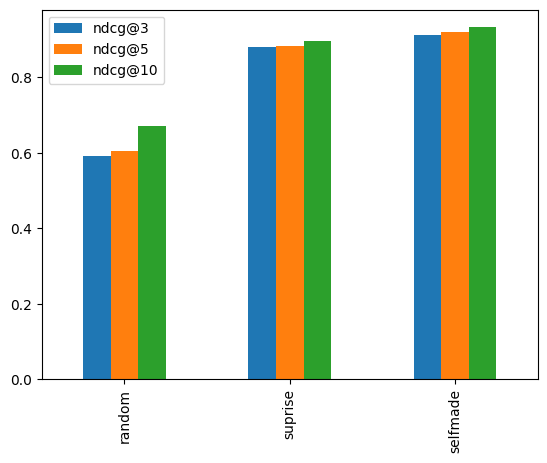

In [19]:
show_df = pd.DataFrame(
    [
        random_eval,
        surpr_evaluate,
        self_evaluate
    ],
    index = [
        "random",
        "suprise",
        "selfmade"
    ]
)
display(show_df)
show_df.plot(kind="bar")
plt.show()

## Evaluation performance

### Surprise

In [20]:
reader = Reader(
    rating_scale=(
        R.min().min(), R.max().max()
    )
)
items_list = list(set(R_frame.index.get_level_values(1)))

In [21]:
%%timeit
train_set = Dataset.load_from_df(
    df=R_fr_train["rank"].reset_index(), 
    reader=reader
).build_full_trainset()
algo = KNNWithMeans(verbose=False).fit(train_set)

[
    algo.predict(uid=20, iid=item_ids).est 
    for item_ids in items_list
]

279 ms ± 19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Self made

In [22]:
%%timeit
collaborative_filter.predict(R_mat_train.loc[[20]].to_numpy())

44.1 ms ± 2.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Real world data

In [23]:
url = "https://files.grouplens.org/datasets/movielens/ml-100k.zip"
response = requests.get(url)

with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    with z.open('ml-100k/u.data') as f:
        col_names = ['user_id', 'item_id', 'rating', 'timestamp']
        movies = pd.read_csv(f, sep='\t', names=col_names)

With surprise we can use only those users/items that were encountered in the training sample.

In [24]:
# runx allows only strings for indeces
movies["user_id"] = movies["user_id"].astype("str")
movies["item_id"] = movies["item_id"].astype("str")

test_movies = movies.loc[movies['timestamp'] > movies['timestamp'].quantile(0.8)]
train_movies = movies.loc[~movies.index.isin(test_movies.index)]

# with surprise we can use only users and items which
# were in the train sample
users_from_train_mask = test_movies["user_id"].isin(train_movies["user_id"])
movies_from_train_mask = test_movies["item_id"].isin(train_movies["item_id"])
test_movies = test_movies.loc[users_from_train_mask & movies_from_train_mask]

movies_qrels = Qrels.from_df(
    df=test_movies,
    q_id_col="user_id", 
    doc_id_col="item_id",
    score_col="rating"
)

In [25]:
reader = Reader(
    rating_scale=(
        movies["rating"].min(), 
        movies["rating"].max()
    )
)
train_set = Dataset.load_from_df(
    df=train_movies[["user_id","item_id", "rating"]], 
    reader=reader
).build_full_trainset()
algo = KNNWithMeans().fit(train_set)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [26]:
test_movies["surpr_predict"] = test_movies.apply(
    lambda row: algo.predict(
        uid=row["user_id"], 
        iid=row["item_id"]
    ).est, 
    axis = 1
)

In [29]:
surprise_run = Run.from_df(
    df=test_movies,
    q_id_col="user_id",
    doc_id_col="item_id",
    score_col="surpr_predict"
)
surpr_evaluate = evaluate(
    movies_qrels, 
    surprise_run, 
    metrics=metrics
)
display(surpr_evaluate)

{'ndcg@3': 0.9136955191425511,
 'ndcg@5': 0.920076825419864,
 'ndcg@10': 0.9328469215058407}